<a href="https://colab.research.google.com/github/mb1te/SMPR/blob/main/SMPR_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**0. Загрузка датасета**

In [ ]:
import seaborn as sns
df = sns.load_dataset('iris')
X = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
y = df[['species']]

**Метод парзеновского окна**

Ниже реализован классификатор, реализующий метод парзеновского окна.

Алгоритм:

Мы присваиваем вес каждому объекту выборки не на основе ранга близости $i$-го объекта к классифицируемому, а на основе расстояния от классифицируемого объекта до данного объекта выборки.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

"""
Классификатор, реализующий метод парзеновского окна
"""
class ParsenWindowClassifier:
  """
  Конструктор класса
  x -- pandas.DataFrame с признаками
  y -- pandas.Series с метками классов
  K -- функция, реализующая ядро

  Сохраняет в класс признаки с метками, их длину, 
  запускает обучение модели.
  """
  def __init__(self, X, y, K):
    self._X = X
    self._size = len(X)
    self._y = y
    self._K = K
    self.train()
  
  """
  Метод обучения модели, вызывает метод, который находит оптимальное h
  """
  def train(self):
    self._h = self._get_optimal_h()

  """
  Геттер для получения вычисленного оптимального значения h
  """
  @property
  def h(self):
    return self._h
  
  """
  Статический метод, реализующий евклидово расстояния
  a, b -- numpy.Array, содержащий координаты объекта 
  """
  @staticmethod
  def _distance(a, b):
    return np.sqrt(np.sum((a - b)**2))

  """
  Метод находящий оптимальное значение h.
  В LOO перебираются значения h от 0.4 до 1.5 с шагом 0.1.
  Такие границы обусловлены тем, что при больших значениях h
  в окно попадает слишком много объектов и потери сильно растут.
  Создается словарь label_counter с счетчиком меток классов.
  Считаются потери, затем возвращается оптимальное h.
  """
  def _get_optimal_h(self):
    distances = {}
    max_dist = 0
    for i in range(self._size):
      for j in range(i + 1, self._size):
        if i == j:
          continue
        d = self._distance(self._X.iloc[i].values, self._X.iloc[j].values)
        distances[i, j] = distances[j, i] = d
        max_dist = max(max_dist, d)
    
    min_h, max_h, step = 0.4, 1.6, 0.1
    losses = [0] * 13
    for drop_index in range(self._size):
      i = 0
      while min_h + i * step <= max_h:
        cur_d = {}
        for xi in range(self._size):
          if xi == drop_index:
            continue

          d = distances[drop_index, xi]
          label = self._y.iloc[xi].values[0]
          if label not in cur_d:
            cur_d[label] = 0
          cur_d[label] += self._K(d / (min_h + i * step))
        
        pred_label = max(cur_d, key=cur_d.get)
        label = self._y.iloc[drop_index].values[0]
        if label != pred_label:
          losses[i] += 1
        i += 1
    self._losses = [i / (self._size - 1) for i in losses]      
    h = 0.4 + np.argmin(losses) * 0.1
    return h

  """
  Метод visualize_training визуализирует потери для различных h.
  Использует данные о потерях сохраненные в _losses при подсчете 
  оптимального h.
  """     
  def visualize_training(self):
        x_axis = [tick for tick in np.arange(0.4, 1.6, 0.1)]
        plt.plot(x_axis, self._losses)
        plt.plot(self._h, np.min(self._losses), 'go')
        plt.show()
        print(f'min at h = {self._h}')
  
  """
  Метод predict предсказывает метки классов для новых объектов.
  x_pred - pandas.DataFrame с признаками новых объектов.
  По каждом объекту считается вес для каждой метки. Находится 
  метка класс с максимальным значением веса.
  Возвращается pandas.Series с предсказанными метками.
  """
  def predict(self, x_pred):
        predicted = []
        for obj in x_pred.values:
            label_counter = {}
            for xi in range(self._size):
                cur_label = self._y.iloc[xi].values[0]
                if cur_label not in label_counter:
                  label_counter[cur_label] = 0
                d = self._distance(obj, self._X.iloc[xi].values)
                label_counter[cur_label] += self._K(d / self._h)
            label = max(label_counter, key=label_counter.get)
            if label_counter[label] > 10**(-3):
              predicted.append(label)
            else:
              predicted.append(-1)
        return pd.Series(predicted)

Ниже представлено 5 ядер для парзеновского окна:

Прямоугольное ядро: $K(z) = \frac{1}{2}[|z| < 1]$

Треугольное ядро: $K(z) = (1 - |z|) \cdot [|z| < 1]$

Ядро Епанечкина: $K(z) = \frac{3}{4} (1 - z^2) \cdot [|z| < 1]$

Квартическое ядро: $K(z) = \frac{15}{16} (1 - z^2)^2 \cdot [|z| < 1]$

Гауссов ядро: $K(z) = \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2}z^2}$

In [ ]:
import math
kernels = [
           ('Прямоугольное ядро', lambda z: 1/2 * (abs(z) < 1)),
           ('Треугольное ядро', lambda z: (1 - abs(z)) * (abs(z) < 1)),
           ('Ядро Епанечкина', lambda z: 3/4 * (1 - z**2) * (abs(z) < 1)),
           ('Квартическое ядро', lambda z: 15/16 * (1 - z**2)**2 * (abs(z) < 1)),
           ('Гауссово ядро', lambda z: 1/(2 * math.pi)**.5 * math.exp(-.5 * z**2))
]


Функция для построения карты классификации

In [ ]:
from matplotlib.patches import Rectangle, Patch
from matplotlib.markers import MarkerStyle
import pandas as pd

"""
Функция построения карты классификации.
K -- ядро для парзеновского окна
i -- признак по оси OX
j -- признак по оси OY

Функция формирует карты классификации с шагом 0.1
Объекты обучающей выборка представлены закрашенными кругами,
остальная область - незакрашенными.
"""

def draw_classification_map(K, i='sepal_length', j='sepal_width'):
  PWC = ParsenWindowClassifier(X[[i, j]], y, K)
  color = {'virginica': 'blue', 'versicolor': 'red', 'setosa': 'green'}
  fig, ax = plt.subplots()

  for xi in np.arange(X[i].min(), X[i].max(), 0.1):
    for yi in np.arange(X[j].min(), X[j].max(), 0.1):
      cat = PWC.predict(pd.DataFrame([(xi, yi)]))
      if cat.values[0] != -1:
        plt.scatter(xi, yi, color='none', 
                  edgecolor=color[cat.values[0]])

  for ind in range(len(X)):
    plt.scatter(X[i].values[ind], X[j].values[ind], 
               color=color[y.values[ind][0]])

  plt.legend(handles=[Patch(color=color[key], label=key) for key in color])

  plt.xlim(X[i].min(), X[i].max())
  plt.ylim(X[j].min(), X[j].max())
  plt.show()
    

Ниже представлены графики изменения потерь $LOO(h)$ и карты классификации для каждого из выше представленных ядер

Прямоугольное ядро


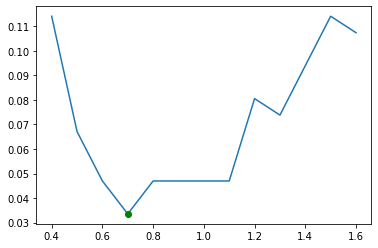

min at h = 0.7000000000000001


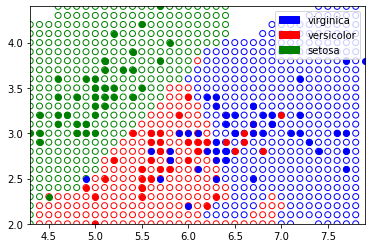

Треугольное ядро


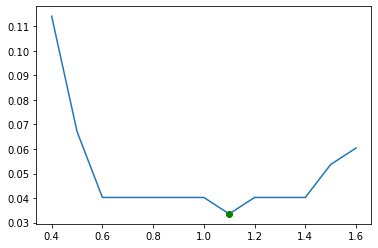

min at h = 1.1


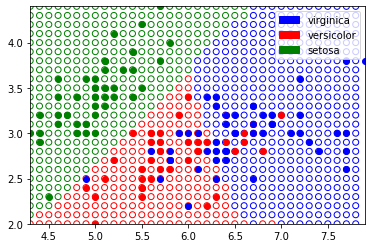

Ядро Епанечкина


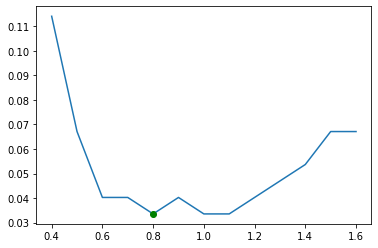

min at h = 0.8


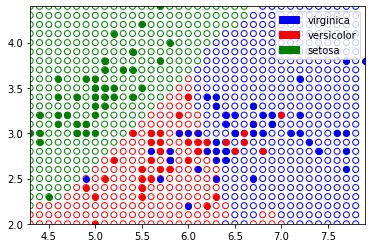

Квартическое ядро


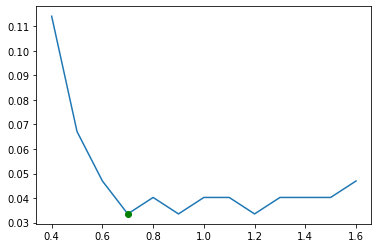

min at h = 0.7000000000000001


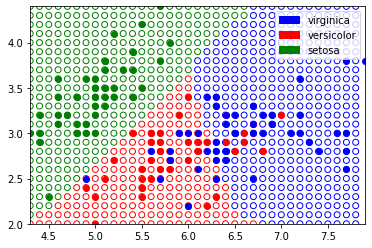

Гауссово ядро


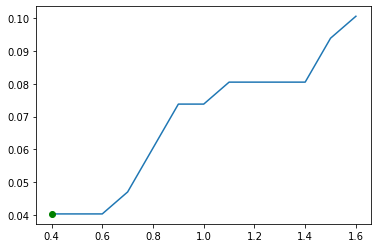

min at h = 0.4


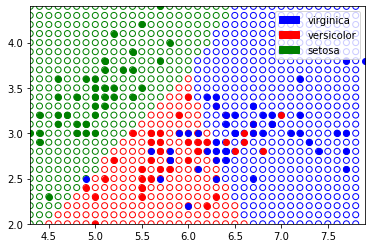

In [ ]:
for i in kernels:
  PWC = ParsenWindowClassifier(X, y, i[1])
  print(i[0])
  PWC.visualize_training()
  draw_classification_map(i[1])

У метода Парзеновского окна есть один существенный недостаток. Если в окно не попадает ни один объект из выборки, то мы не можем классифицировать новый объект. Особенно ярко эта проблему мы замечаем на запуске с прямоугольным ядром. А на запуске с гауссовым ядром такой проблемы вообще не будет.

В целом же модели показывают сравнимый результат ($loss = 0.033$). Модели KNN показывали сравнимый с этим результат. Это связаным с малым числом объектов в тестовой выборке.